In [1]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
hs_2017 = pd.read_csv("https://github.com/jeffweltman/MSDS7331/raw/master/hs_2017.csv",index_col=0)
hs_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 469
Columns: 395 entries, student_num to nc_district
dtypes: float64(323), int64(72)
memory usage: 1.3 MB


Let's remove the columns that are largely lacking data (mostly one-hot encoded variables) and see if that affects our clustering performance.

In [2]:
# Preparing the Classification variables
Y_class = hs_2017['sat_high_level']
X_class = hs_2017.drop(columns=['nc_district', 'sat_high_level', 'sat_avg_score_num'])

from sklearn.preprocessing import StandardScaler

# Standardize the data to a more normally distributed data
scaler_class = StandardScaler()
scaler_class.fit(X_class)

StandardScaler(copy=True, with_mean=True, with_std=True)

As our previous work demonstrated, the most accurate classifier we've configured for use with this data set is the Random Forest classifier. We'll therefore instantiate that as the model upon which we'll cluster.

In [3]:
#Divide data into test and training splits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, recall_score, f1_score


# Generate a 90/10 training/test split of data
X_train, X_test, y_train, y_test = train_test_split(X_class, Y_class, test_size=0.1, random_state=0)

# Generate & train instance of RandomForest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# EvaluateClassifierEstimator(rf, X_class, Y_class, cv_class)

C:\Users\jeffw\Anaconda3\envs\MSDS7331\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

First we run the KMeans with the default 8 clusters.

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

cv_class = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

# X1 = df_imputed[['Pclass','Fare']]
clf = rf

cls = KMeans(n_clusters=8, init='k-means++',n_init=10,random_state=1)
cls.fit(X_class)
newfeature = cls.labels_ # the labels from kmeans clustering

# y = df_imputed['Survived']
# X = df_imputed[['Age','IsMale','Parch','SibSp']]
X = np.column_stack((X_class,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=Y_class,cv=cv_class)

print ("Average accuracy (with kmeans)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans)=  86.51162790697674 +- 4.855956515772347


Let's see if we can improve upon accuracy and/or standard deviation.  

By utilizing the 'Elbow method', we attempt to identify the optimal number of clusters as identified by the inflection point, or 'elbow', achieved at the point where the SSE reaches an observably low point.  
  
What we see instead is a smooth curve which indicates that the data may not be very clustered.  
(See Robert Gove's Block: https://bl.ocks.org/rpgove/0060ff3b656618e9136b) 

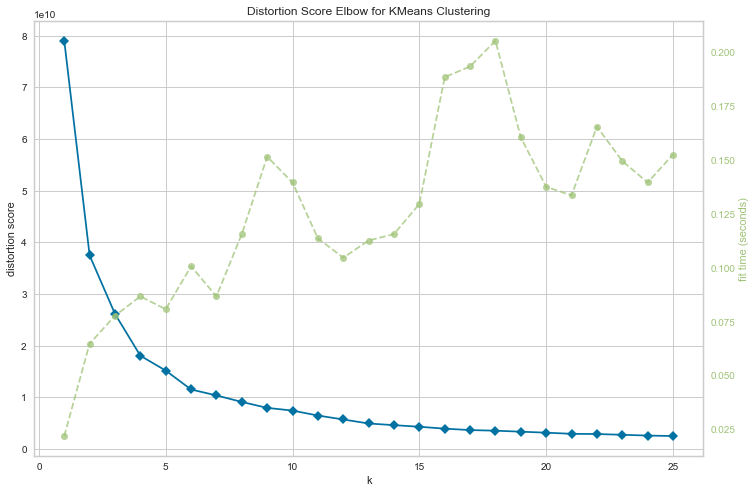

In [6]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from matplotlib import pyplot
import seaborn as sns

newdims = (12, 8)
fig, ax = pyplot.subplots(figsize=newdims)

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(KMeans(), k=(1,26)) #curve continues smoothly beyond 25 clusters

visualizer.fit(X_class) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

We'll turn then to silhouette scores.
We'll run a *for each* loop to compute the silhouette coefficient - as well as the mean accuracy and standard deviation - for KMeans with 2-200 clusters.  
We'll output the results to a dataframe for analysis.

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import pairwise_distances

cv_class = StratifiedShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

clf = rf

cluster_performance = []

for i in range(2,201):
    cls = KMeans(n_clusters=i, init='k-means++',n_init=10,random_state=1)
    cls.fit(X_class)
    newfeature = cls.labels_ # the labels from kmeans clustering


    X = np.column_stack((X_class,pd.get_dummies(newfeature)))

    acc = cross_val_score(clf,X,y=Y_class,cv=cv_class)
    cluster_performance.append({'Clusters': i, 'Accuracy': acc.mean()*100, 'SD': acc.std()*100, 'Silhouette':metrics.silhouette_score(X, newfeature, metric='euclidean') })

cluster_performance = pd.DataFrame(cluster_performance)
cluster_performance = cluster_performance[['Clusters','Accuracy','SD', 'Silhouette']] #enforcing column order

In [12]:
cluster_performance.head().style.hide_index()

Clusters,Accuracy,SD,Silhouette
2,85.1163,5.3235,0.643422
3,86.0465,5.69649,0.59118
4,86.7442,4.65697,0.601376
5,85.1163,5.11628,0.591486
6,86.5116,3.57263,0.601232


The lowest standard deviation achievable, when utilizing k-means with a number of batches between 2 and 200, is 2.279, achieved with 114 clusters.

In [13]:
lowest_sd = cluster_performance.sort_values(by='SD',ascending=True)
lowest_sd.head(1).style.hide_index()

Clusters,Accuracy,SD,Silhouette
114,85.5814,2.2786,0.73498


The sweet spot of highest accuracy within a palatable standard deviation is achievable with either 17 clusters or 199 clusters.
In both cases, the mean accuracy increases from 85.581 to 87.442.  
For 17 clusters, the standard deviation is 3.632.  
For 199 clusters, the standard deviation is 3.481.

In [15]:
balanced = cluster_performance[['Clusters','Accuracy','SD']].sort_values(
    by='Accuracy',ascending=False).head(15)
balanced.style.background_gradient(cmap='GnBu_r', subset='SD').background_gradient(
    cmap='GnBu', subset='Accuracy').hide_index()

Clusters,Accuracy,SD
89,89.0698,5.40916
177,88.3721,5.30314
55,88.1395,4.088
192,87.907,3.57263
159,87.907,3.72093
199,87.4419,3.48061
143,87.4419,5.3235
11,87.4419,4.43693
39,87.4419,5.8093
155,87.4419,3.91914


The silhouette coefficient tends to increase as the number of clusters approaches 100, with the highest mean silhouette coefficient achieved at 98 clusters.  
The silhouette coefficient then begins to decrease, indicating that the optimal number of k-means clusters is between 90 and 100. 

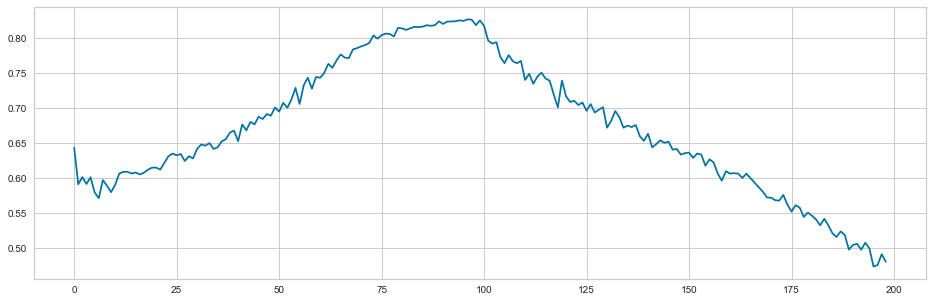

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
 
# create data
values=cluster_performance[['Silhouette']]

newdims = (16, 5)
fig, ax = plt.subplots(figsize=newdims)

# use the plot function
plt.plot(values)

The highest silhouette coefficient - 0.827 - is found with 98 clusters, but a standard deviation of 5.226 indicates high variance.  
Below we look at the ten highest silhouette coefficient scores to include accuracy and standard deviation.  

With 92 clusters, we can achieve 85.814% accuracy with a much tighter variance of on 2.641. This looks to be the optimal number of k-means clusters.

In [18]:
best_silhouette = cluster_performance.sort_values(by='Silhouette',ascending=False)
best_silhouette.head(15).style.background_gradient(cmap='GnBu_r', subset='SD').background_gradient(
    cmap='GnBu', subset='Accuracy').hide_index()

Clusters,Accuracy,SD,Silhouette
98,87.2093,5.22609,0.827314
99,85.5814,5.07382,0.826925
96,86.2791,4.088,0.825872
101,86.0465,5.40416,0.825824
97,86.7442,4.53935,0.825172
95,86.7442,5.60557,0.824556
91,85.5814,3.41789,0.824481
94,84.6512,5.52295,0.824296
93,84.186,5.5814,0.824077
92,85.814,2.64135,0.820748


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

Below we visualize a scatter plot, labelled using our clusters.  
Interpreting this with 92 different labels may be approaching useless, but...there it is!

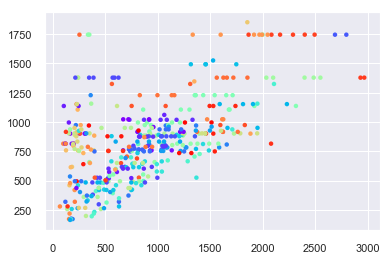

In [20]:
labels = KMeans(n_clusters=92, init='k-means++',n_init=10,random_state=1).fit_predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis');
plt.scatter(X[:, 0], X[:, 1]+np.random.random(X[:, 1].shape)/2, c=newfeature, cmap=plt.cm.rainbow, s=20, linewidths=0)

Below we visualize the cluster density and size via a silhouette graph, and plot the cluster centers.

Automatically created module for IPython interactive environment
For n_clusters = 92 The average silhouette_score is : 0.82239523584728


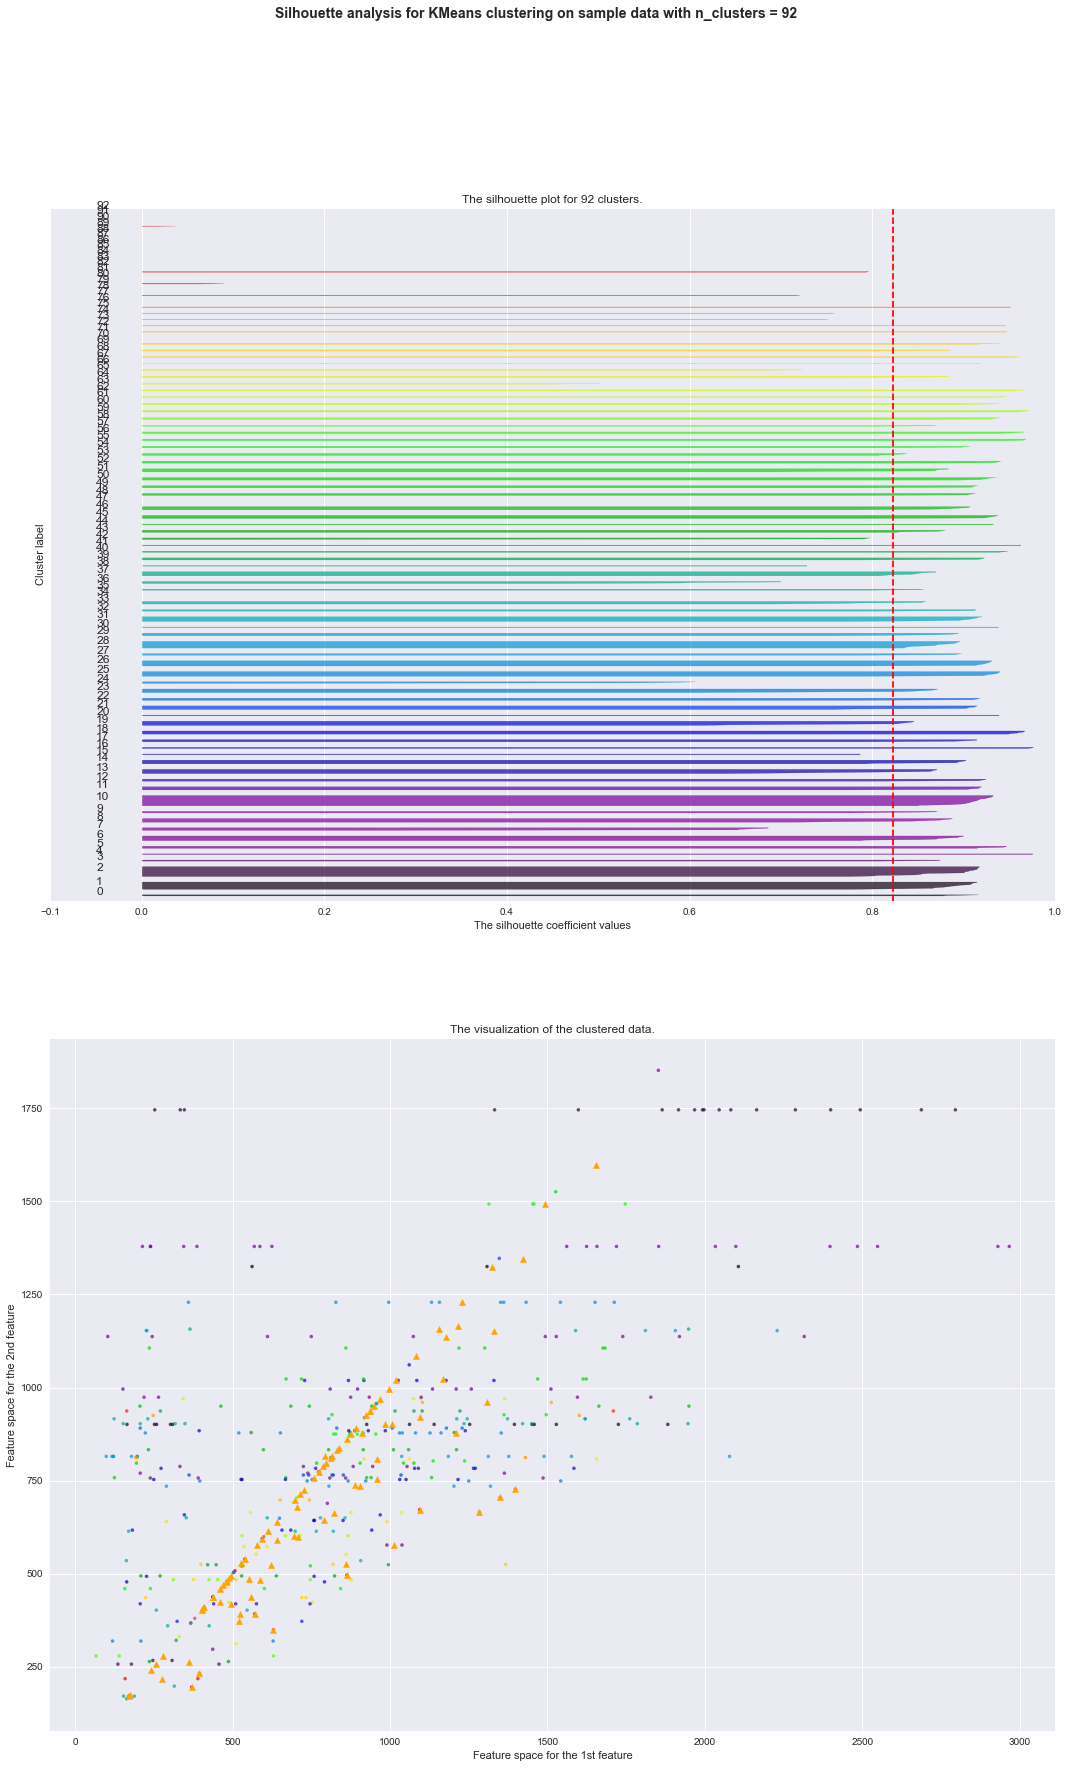

For n_clusters = 96 The average silhouette_score is : 0.8284828163552127


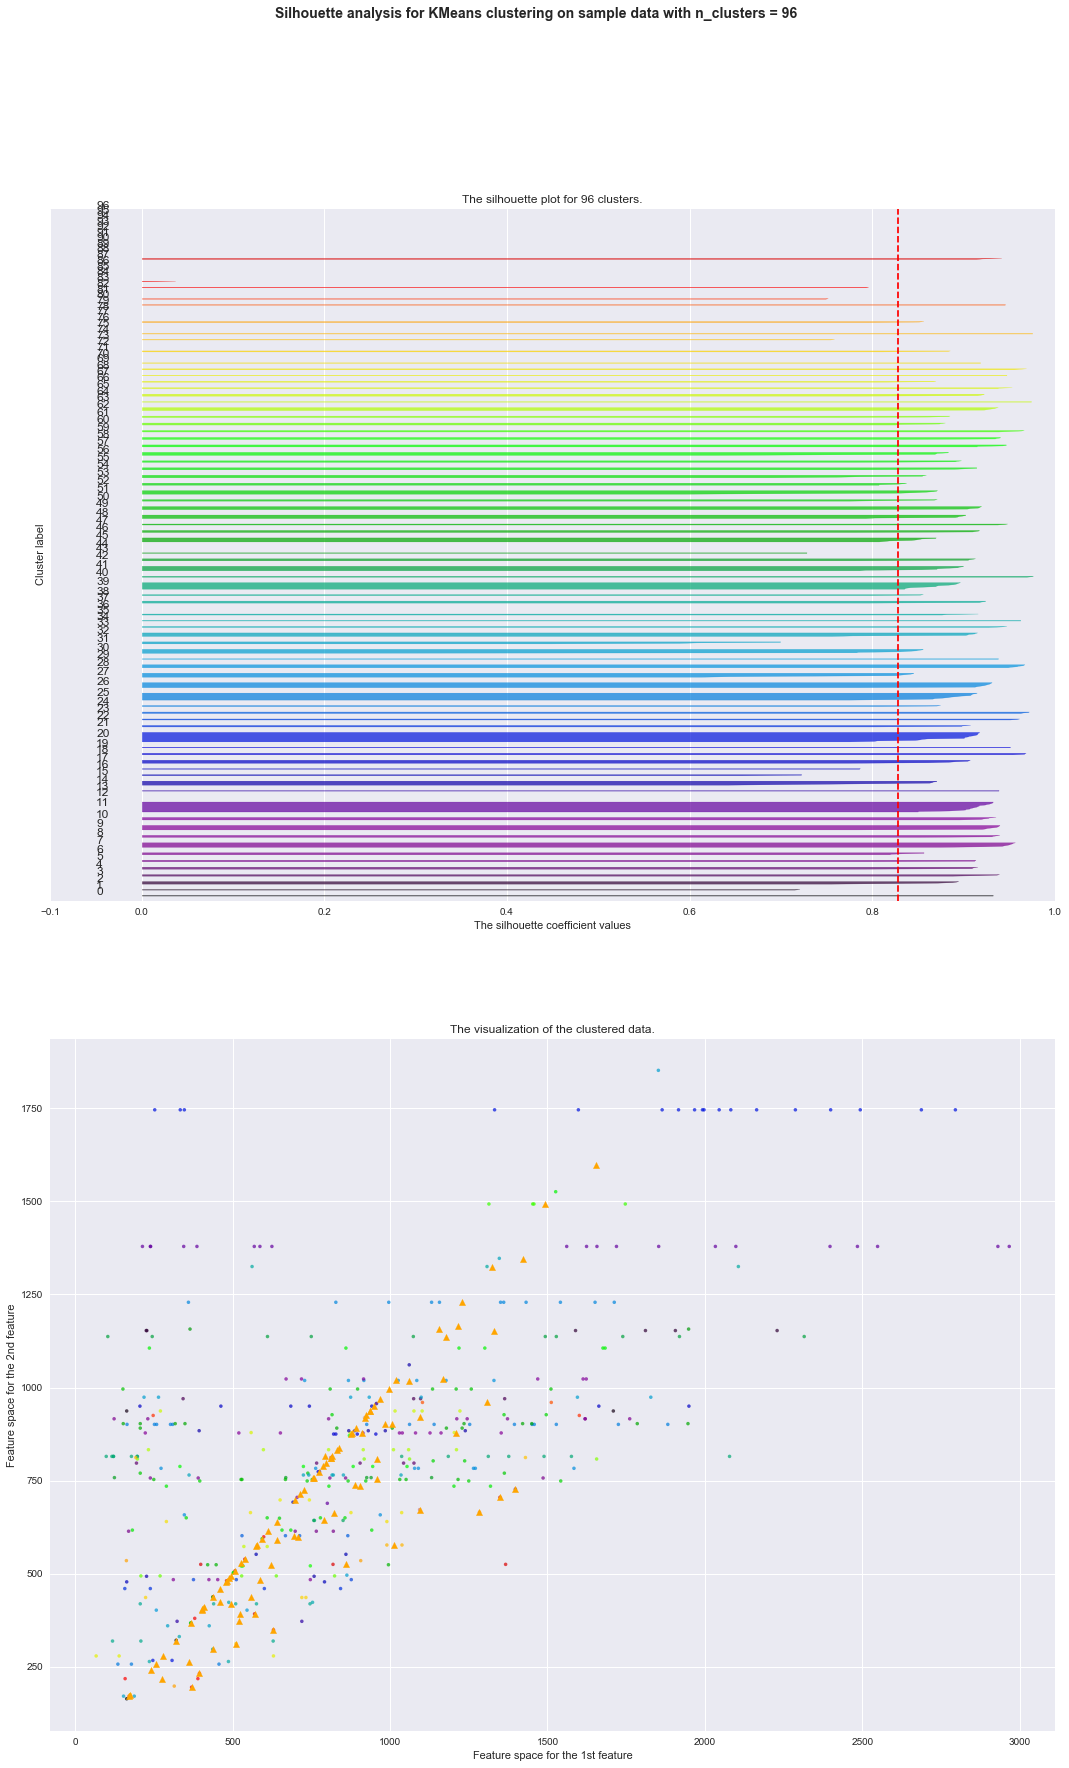

For n_clusters = 98 The average silhouette_score is : 0.8273140954403805


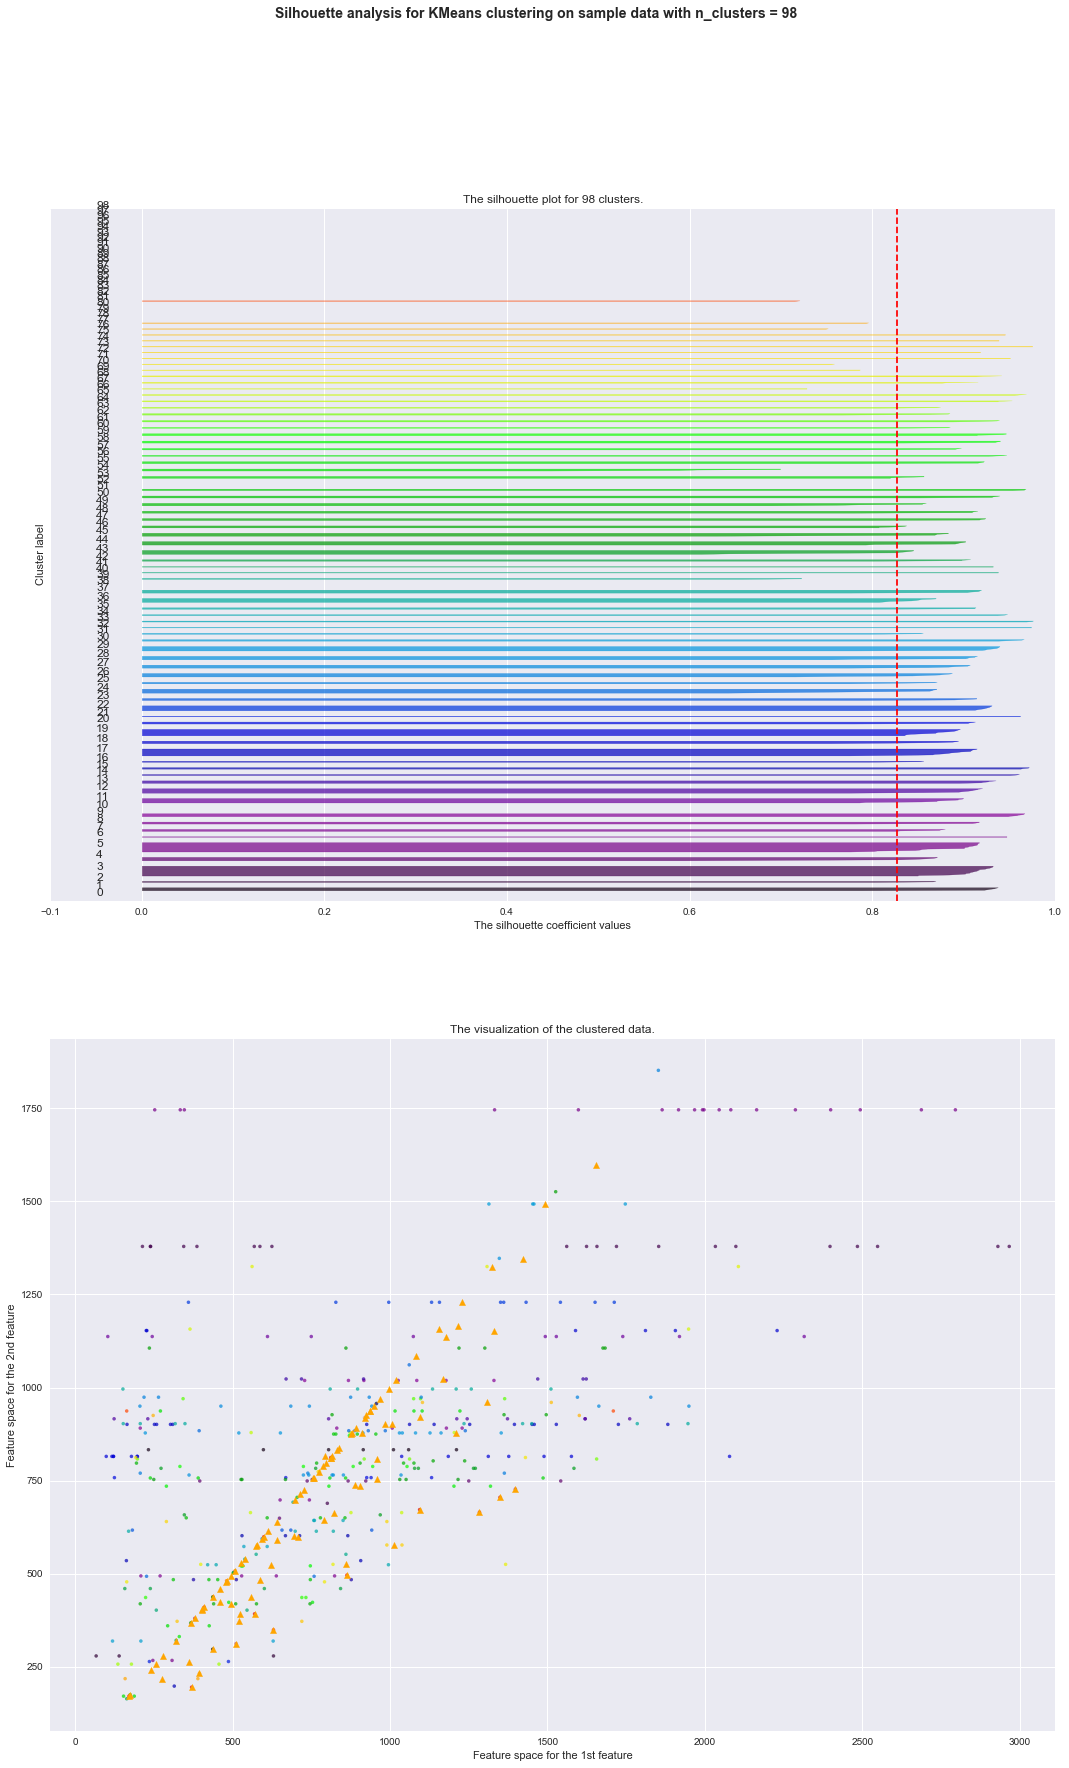

For n_clusters = 99 The average silhouette_score is : 0.8269250219648459


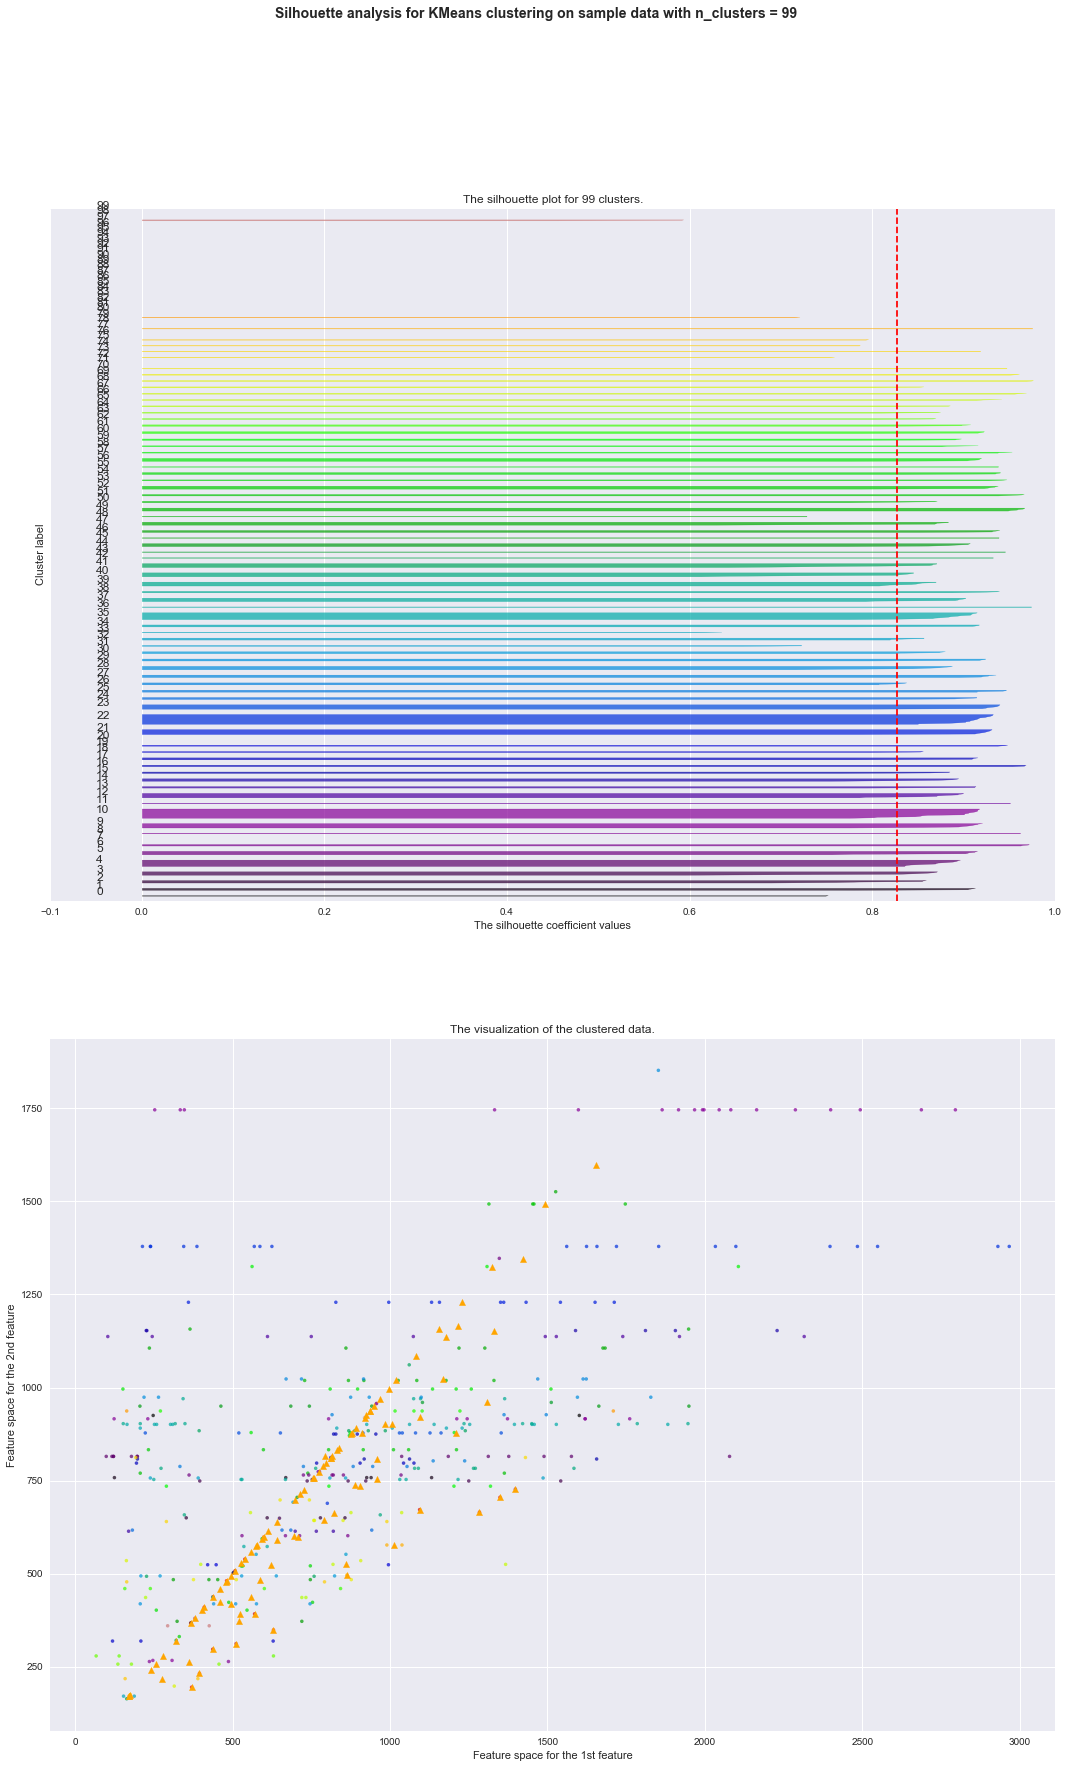

In [53]:
# adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

range_n_clusters = [92,96,98,99]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(2,1)
    #fig = plt.figure(ax=ax1)
    #fig = plt.figure(ax=ax2)
    fig.set_size_inches(18, 28)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for {} clusters.".format(i))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=50, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw orange triangles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='^',
                c="orange", alpha=1, s=40)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

Next, we'll look at Agglomerative Clustering.

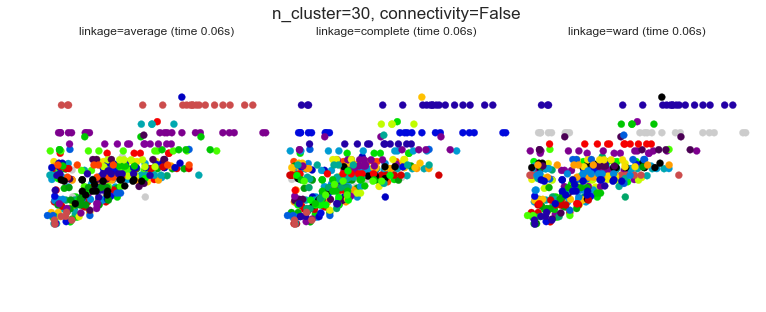

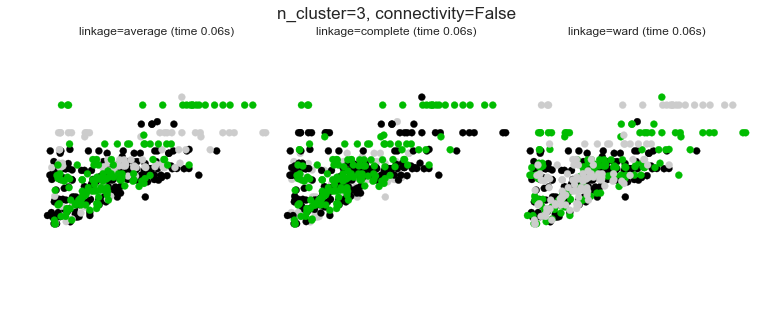

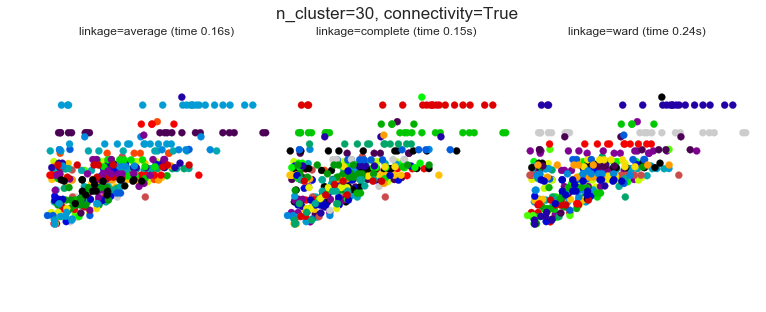

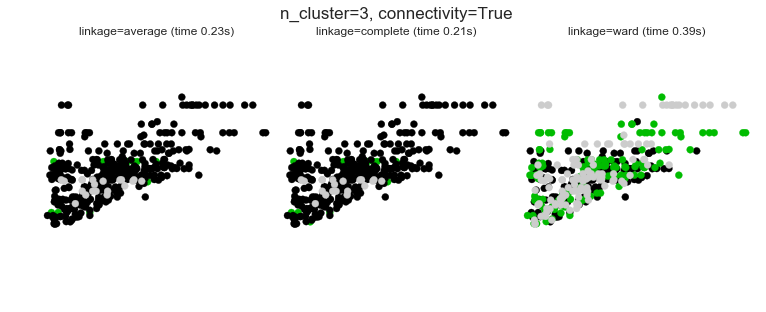

In [12]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
#t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = X_class
y = Y_class

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)
            

plt.show()

Thirdly, we'll look at HDBSCAN, a hierarchical implementation of DBSCAN for non-spherical data.  
See https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a,  
https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a

Silhouette Coefficient: 0.673
Silhouette Coefficient: 0.723
Silhouette Coefficient: 0.592
Silhouette Coefficient: 0.553
Silhouette Coefficient: 0.514
Silhouette Coefficient: 0.479
Silhouette Coefficient: 0.476
Silhouette Coefficient: 0.411
Silhouette Coefficient: 0.377
Silhouette Coefficient: 0.396
Silhouette Coefficient: 0.399
Silhouette Coefficient: 0.367
Silhouette Coefficient: 0.392
Silhouette Coefficient: 0.382
Silhouette Coefficient: 0.296
Silhouette Coefficient: 0.359
Silhouette Coefficient: 0.333
Silhouette Coefficient: 0.339
Silhouette Coefficient: 0.292


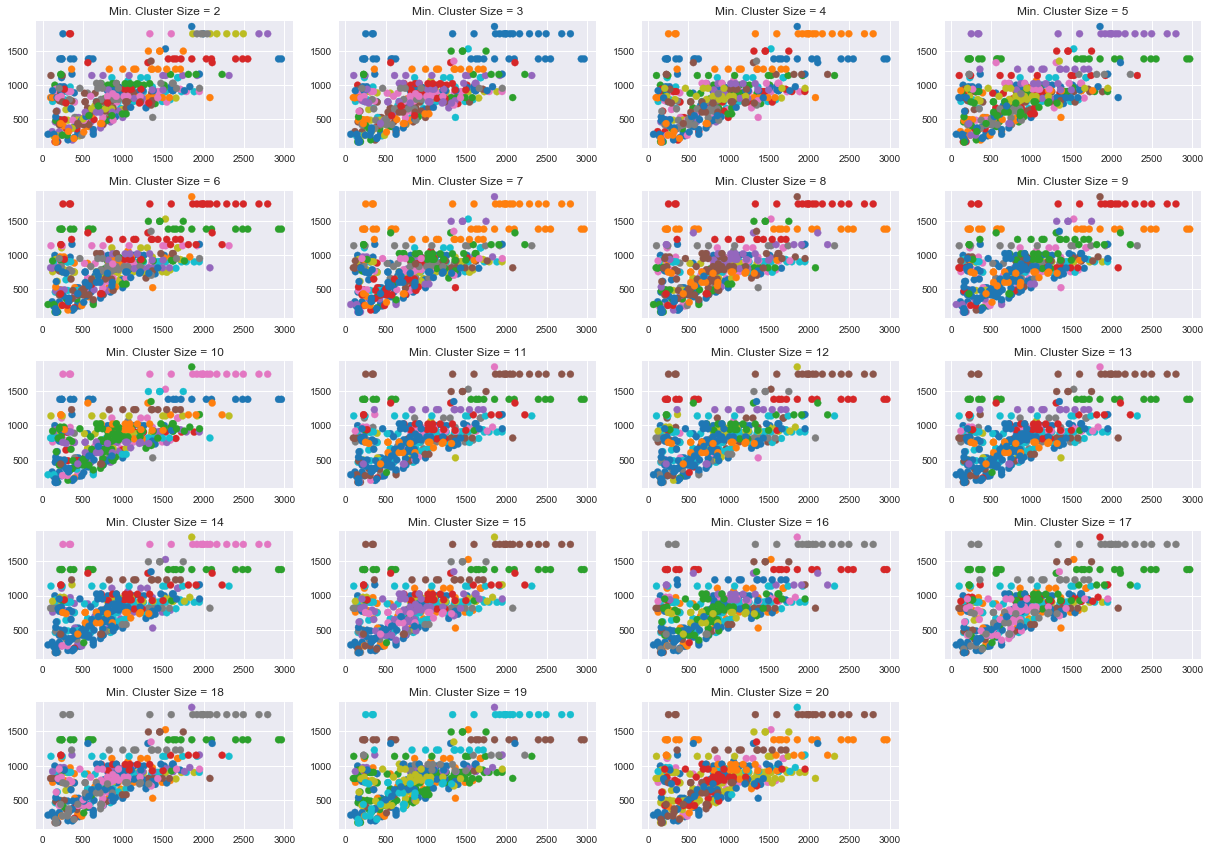

In [11]:
import hdbscan

plt.style.use('seaborn')
cmap = 'tab10'

clust_count = np.linspace(1, 20, num=20, dtype='int')

clust_number = 2
plot_number = 1
plt.figure (figsize=(17,12))
while clust_number < 21:
    hdb = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=clust_number, min_samples=None, p=None)
    hdb_pred = hdb.fit(hs_2017)
    plt.subplot(5, 4, plot_number, title = 'Min. Cluster Size = {}'.format(clust_number))
    plt.scatter(hs_2017.values[:,0], hs_2017.values[:,1], c=hdb_pred.labels_, cmap=cmap)
    plot_number += 1
    clust_number += 1
    labels = hdb.labels_
    print("Silhouette Coefficient: %0.3f"
                  % metrics.silhouette_score(X, labels, metric='euclidean'))

plt.tight_layout()